In [50]:
using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization, OptimizationOptimJL,
      OptimizationOptimisers, Random, Plots
using ArrheniusModel
using RecursiveArrayTools
using Statistics

In [51]:
function arrhenius_rate(pe::PhaseEnergies, T=300)
    kb = 8.617e-5 #eV/K
    A = 1.0 # Arrhenius prefactor
    pe.K = A * exp.(-pe.Ea_plus_ΔG ./ (kb * T))
    # Adjust the diagonal elements
    for i in 1:size(pe.K, 1)
        pe.K[i, i] =  -1 * sum(pe.K[i, [1:i-1; i+1:end]])
    end
end

arrhenius_rate (generic function with 2 methods)

In [52]:
rng = Xoshiro(0)
G = [-5.92, -5.942, -5.97]
Ea = [0.00 1.00 0.01; 1.00 0.00 1.00; 0.01 1.00 0.00]
pe = PhaseEnergies(G, Ea)
T = 300.0
t= 10
dt = 0.05
datasize = Int(t/0.5+1)
num_steps = floor(Int, t/dt)
num_layers = floor(Int, t/0.5)+1
flow_rate = 0.5
decay_coefficient = 0.00001 * flow_rate
fcoeff = flow_coefficient("exponential", num_layers, decay_coefficient)

function deposition_rates!(dc, c, p, t)
    # Unpack parameters
    fcoeff, pe, j0, j, dt, num_steps, num_layers = p
    # Calculate deposition rates
    j = floor(Int, t / 0.5) + 1
    f = reverse(fcoeff[j: num_layers+j-1])
    dc .= c .* f * pe.K
    if j != j0
        c[j+1, 1] = 1.0
        j = j0
    end
end

n = n_phases(pe)
c0 = zeros(num_layers, n)
c0[1, 1] = 1.0
arrhenius_rate(pe, T)
j = 0
j0 = 0
p = (fcoeff, pe, j0, j, dt, num_steps, num_layers)
tspan = (0.0, (num_steps-1) * dt)
tsteps = range(tspan[1], tspan[2]; length = datasize)
prob = ODEProblem(deposition_rates!, c0, tspan, p)
ode_data = Array(solve(prob, Euler(), saveat = 0.5, dt = dt)) #Training data
ode_data_avg = mean(ode_data, dims=1)
ode_data_avg = reshape(ode_data_avg, (3, 21))

3×21 Matrix{Float64}:
 0.047619  0.081621     0.155214     0.173523     …  0.298417    0.259249
 0.0       3.42976e-19  9.37616e-19  1.81087e-18     3.9491e-17  4.28866e-17
 0.0       0.0136171    0.0352625    0.0645725       0.701583    0.740751

In [53]:
inputs = [T, flow_rate]
input_size = length(inputs)  # Replace with the actual size of `inputs` if it's not a 1D vector
Ea_size = n ^ 2 
fcoeff_size = length(fcoeff) #sigmoid 0~1
precoeff_size = 1
output_size = Ea_size + fcoeff_size + precoeff_size
nn = Chain(
    Dense(input_size, 34, tanh),
    Dense(34, 102, tanh),
    Dense(102, output_size, sigmoid)
)
#Combine activation functions and setup constraints
#Normalize the input


Chain(
    layer_1 = Dense(2 => 34, tanh_fast),  # 102 parameters
    layer_2 = Dense(34 => 102, tanh_fast),  # 3_570 parameters
    layer_3 = Dense(102 => 51, sigmoid_fast),  # 5_253 parameters
)         # Total: 8_925 parameters,
          #        plus 0 states.

In [54]:
#For debugging

dp, dst = Lux.setup(rng, nn)
model_debug = Lux.Experimental.@debug_mode nn

try
    model_debug(inputs, dp, dst)
catch e
    println(e)
end

┌ Info: Input Type: Vector{Float64} | Input Structure: (2,)
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:68
┌ Info: Running Layer: Dense(2 => 34, tanh_fast) at location KeyPath(:nn, :layers, :layer_1)!
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:69
┌ Info: Output Type: Vector{Float64} | Output Structure: (34,)
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:83
┌ Info: Input Type: Vector{Float64} | Input Structure: (34,)
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:68
┌ Info: Running Layer: Dense(34 => 102, tanh_fast) at location KeyPath(:nn, :layers, :layer_2)!
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:69
┌ Info: Output Type: Vector{Float64} | Output Structure: (102,)
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:83
┌ Info: Input Type: Vector{Float64} | Input St

([0.7357634917436715, 0.4485063829469547, 0.5029312670454553, 0.36201436574713397, 0.8009284520922859, 0.5597125678569552, 0.4793949637589109, 0.5675578737509103, 0.5941570958131658, 0.4417816101358834  …  0.5572608404080263, 0.758719779511766, 0.1955373660439674, 0.6567668751714307, 0.6757855540546611, 0.20779333046274193, 0.32504406692132204, 0.3280215412408576, 0.4356478295349405, 0.3879441351960937], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [55]:
p, st = Lux.setup(rng, nn)

((layer_1 = (weight = Float32[-0.17049775 -0.19497958; -0.18730314 -0.37751564; … ; -0.28133458 0.26355112; -0.122697756 -0.15053937], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[-0.021555088 -0.005538818 … -0.20111066 -0.049338292; -0.05499049 0.18305092 … -0.18121664 0.16598503; … ; 0.1881638 0.13129972 … 0.013943645 -0.094872944; 0.14085263 0.1370397 … 0.19503514 0.12460726], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[-0.15893058 0.043106046 … -0.0833294 -0.007209447; 0.084262416 -0.15995221 … -0.041647326 -0.043202363; … ; -0.008422514 -0.06437325 … -0.07596006 -0.13969865; -0.14695898 -0.04434638 … 0.12367858 0.04967506], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [56]:
println(j,j0,c0)

00[1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]


In [57]:
function model_rates!(du, u, p, t)
    # Unpack parameters
    p_pe, p_fcoeff, p_precoeff = p
    # Calculate deposition rates
    j = floor(Int, t / 0.5) + 1
    f = reverse(p_fcoeff[j: num_layers+j-1])
    du .= p_precoeff * u .* f * p_pe.K
    if j != j0
        u[j+1, 1] = 1.0
        j = j0
    end
end

function predict_neuralode(p)
    # Get parameters from the neural network
    inputs = [0.1, flow_rate] #Normalize 300K to 0.1 at this time point
    output, outst = nn(inputs, p, st)

    # Segregate the output
    p_Ea = output[1:Ea_size]
    p_Ea = reshape(p_Ea, n, n)
    p_fcoeff = output[Ea_size+1:Ea_size+fcoeff_size]
    p_precoeff = output[end]  # The last element
    p_pe = PhaseEnergies(G, p_Ea)
    # Amorphous phase goes to zero
    nn_output = (p_pe, p_fcoeff, p_precoeff)
    arrhenius_rate(p_pe, T)

    # Define the ODE problem with the parameters from the neural network
    prob = ODEProblem(model_rates!, c0, tspan, nn_output)

    # Solve the ODE
    sol = solve(prob, Euler(), saveat = 0.5, dt = dt)
    return Array(sol)
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

T = 300.0  # Example temperature
flow_rate = 1.0  # Example flow rate
#ps = T, flow_rate, p, st, ode_data
# Predict using the NeuralODE
pred = predict_neuralode(p)
println("Training data: ", size(ode_data))
println("Prediction:", size(pred))
println("Training size: ", size(ode_data[:, :, 1]))
println(pred[:, :, 4])
println("prediction size: ", size(pred[:, :, 1]))
#!!Instability happens at 4th timestep since the weights are randomly initialized (num too large)

# Calculate loss
loss, pred = loss_neuralode(p)

println("Loss: ", loss)
println("Prediction: ", pred)

Training data: (21, 3, 21)
Prediction:(21, 3, 21)
Training size: (21, 3)
[0.9999999801232776 1.1134451394581963e-10 1.976537767936568e-8; 0.999999986950304 1.068439001348612e-10 1.8966449032436587e-8; 0.9999999923548771 6.907042931602705e-11 1.2261072720394859e-8; 0.9999999993307115 3.374270667596281e-11 5.989854119914563e-9; 1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
prediction size: (21, 3)
Loss: 230.09804639969815
Prediction: [1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.9999999930241656 3.9076909974540217e-11 6.936757954355695e-9; 1.0 3.3742706675962855e-11 5.989854119914572e-9; 

In [58]:
println(size(ode_data[:,1,:]), ode_data[:,1,:])
println(size(ode_data))
#Average the ode_data to get the average concentration of each phase at every timestep
ode_data_avg = mean(ode_data, dims=1)
ode_data_avg = reshape(ode_data_avg, (3, 21))
println(size(ode_data_avg))
display(ode_data_avg[:,:])

3×21 Matrix{Float64}:
 0.047619  0.081621     0.155214     0.173523     …  0.298417    0.259249
 0.0       3.42976e-19  9.37616e-19  1.81087e-18     3.9491e-17  4.28866e-17
 0.0       0.0136171    0.0352625    0.0645725       0.701583    0.740751

(21, 21)[1.0 0.7140418066239524 0.5216762060296549 0.39227071343540376 0.3052186330850872 0.24665790382769046 0.20726347055526823 0.18076237380129176 0.16293473951705625 0.15094183259120358 0.1428740146711837 0.13744665514935134 0.13379556990798105 0.13133941229777385 0.12968710291440183 0.1285755570563149 0.12782779352898554 0.12732475407337257 0.12698634601215097 0.12675868942146867 0.126618268501075; 0.0 1.0 0.7378108976008431 0.5376659722865966 0.4030271981415452 0.3124546486293472 0.2515256423015424 0.21053806885984885 0.18296524805093942 0.16441665098232047 0.15193874198427695 0.14354465550956397 0.13789780953370603 0.1340990716907807 0.13154358524078993 0.12982445523754738 0.12866795763858224 0.12788995399828396 0.12736657125310205 0.12701447771829566 0.12679730323419702; 0.0 3.648481686647177e-30 1.0000000000000002 0.7140418066239528 0.5216762859778709 0.39227076721741294 0.3052186330854632 0.24665787948969678 0.20726345418274675 0.18076236278723673 0.1629347321077117 0.1509418

In [59]:
propertynames(nn)

(:layers, :name)

In [60]:
propertynames(nn.layers[1])

(:activation, :in_dims, :out_dims, :init_weight, :init_bias)

In [61]:
# Callback function to observe training
loss_values = Float64[]
callback = function (p, l, pred; doplot = false)
    println(l)
    push!(loss_values, l)
    # plot current prediction against data
    if doplot
        pred_avg = mean(pred, dims=1)
        pred_avg = reshape(pred_avg, (3, 21))
        #plot the three phases from ode_data_avg and pred_avg
        plt = scatter(tsteps, ode_data_avg[1, :], label = "Phase 1 Data", color = :blue)
        scatter!(plt, tsteps, ode_data_avg[2, :], label = "Phase 2 Data", color = :red)
        scatter!(plt, tsteps, ode_data_avg[3, :], label = "Phase 3 Data", color = :green)
        scatter!(plt, tsteps, pred_avg[1, :], label = "Phase 1 Prediction", color = :blue, shape = :cross)
        scatter!(plt, tsteps, pred_avg[2, :], label = "Phase 2 Prediction", color = :red, shape = :cross)
        scatter!(plt, tsteps, pred_avg[3, :], label = "Phase 3 Prediction", color = :green, shape = :cross)
        display(plot(plt))
        savefig(plt, "training.png")
    end
    return false
end

pinit = ComponentArray(p)

callback(pinit, loss_neuralode(pinit)...)

230.09804639969815


false

In [62]:
println(typeof(pinit))

ComponentVector{Float32, Vector{Float32}, Tuple{Axis{(layer_1 = ViewAxis(1:102, Axis(weight = ViewAxis(1:68, ShapedAxis((34, 2))), bias = ViewAxis(69:102, ShapedAxis((34, 1))))), layer_2 = ViewAxis(103:3672, Axis(weight = ViewAxis(1:3468, ShapedAxis((102, 34))), bias = ViewAxis(3469:3570, ShapedAxis((102, 1))))), layer_3 = ViewAxis(3673:8925, Axis(weight = ViewAxis(1:5202, ShapedAxis((51, 102))), bias = ViewAxis(5203:5253, ShapedAxis((51, 1))))))}}}


In [63]:
# Train using the Adam optimizer
adtype = Optimization.AutoFiniteDiff()

optf = Optimization.OptimizationFunction((p,_) -> loss_neuralode(p), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

result_neuralode = Optimization.solve(
    optprob, OptimizationOptimisers.Adam(0.02); callback = callback, maxiters = 300)


230.09804639969815
218.53021423129732
20.67623027522666
27.945051298164493
34.484207519695005
21.52938064780112
6.3509693930370315
4.6559702132532195
10.953435921089747
3.7221378446551068
2.1193640124556596
3.622146353280638
4.9566333386733135
5.762680963474271
6.181425203580685
6.32907548260044
6.259004217261886
5.97415145169664
5.43349249197985
4.561340395315269
3.312322534365851
1.9853753972356358
1.9652308964769867
4.03170606638157
3.526005601831261
1.8268867996925884
1.8360088603964317
2.5117198479631937
2.9777577957586105
3.0313822797535908
2.6766902812466222
2.0274188007496003
1.4933599125622672
1.7287017933213122
2.300355608589548
1.9771271722801174
1.4122184326096592
1.394526082792354
1.649356181646677
1.8102647142512103
1.7485216552604084
1.4963443354070765
1.2032926228205922
1.1059497446359063
1.263286308253785
1.2249744965854998
0.96908804654003
0.8969959465859545
0.9879453010201174
1.0215627093448636
0.9155296338481673
0.8013353551135839
0.7998460612927062
0.85250556486292

retcode: Default
u: ComponentVector{Float32}(layer_1 = (weight = Float32[-0.20783038 -0.23222159; -0.31013536 -0.5003774; … ; -0.17130926 0.373616; -0.21246223 -0.24040066], bias = Float32[-0.03724181; -0.12286208; … ; 0.11006481; -0.089861214;;]), layer_2 = (weight = Float32[0.016649242 0.047425278 … -0.24804376 -0.007487567; -0.0851056 0.15467158 … -0.15559885 0.13841377; … ; 0.33705783 0.28358573 … -0.13602497 0.05389379; 0.27717945 0.2791747 … 0.056329407 0.26135308], bias = Float32[-0.06415204; 0.03522946; … ; -0.155623; -0.14738555;;]), layer_3 = (weight = Float32[-0.15893058 0.043106046 … -0.0833294 -0.007209447; 0.03666114 -0.04500939 … -0.07511351 -0.0595066; … ; -0.008422514 -0.06437325 … -0.07596006 -0.13969865; -0.10038637 0.009748317 … 0.090046294 0.011208532], bias = Float32[0.0; 0.004295894; … ; 0.0; 0.061485488;;]))

In [64]:
using Dates
plt = scatter!(loss_values, title="Loss Transformation", xlabel="Iteration", ylabel="Loss")

# Generate a unique filename using the current timestamp
timestamp = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
filename = "loss_transformation_$timestamp.png"

# Save the plot to a file
savefig(plt, filename)

"g:\\My Drive\\Ga2O3\\DiffEqFlux\\loss_transformation_2024-07-30_10-41-16.png"

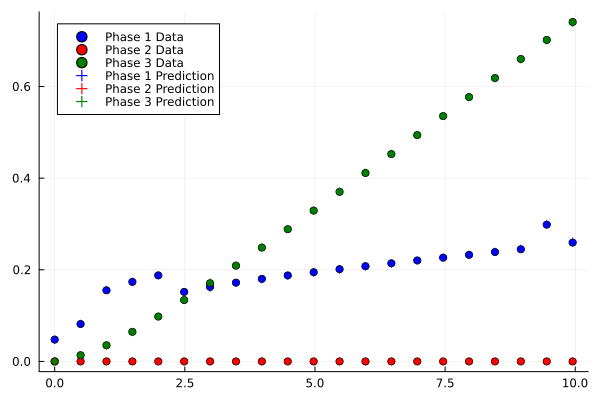

0.09089574429087582


false

In [65]:
callback(result_neuralode.u, loss_neuralode(result_neuralode.u)...; doplot = true)
#scatter!(plt, tsteps, loss_neuralode(result_neuralode.u)[2][1, :]; label = "prediction") # hide

In [66]:
display(predict_neuralode(result_neuralode.u)[:, :, 21])
display(ode_data[:, :, 21])

21×3 Matrix{Float64}:
 0.133692  4.46765e-17  0.866308
 0.137446  4.43566e-17  0.862554
 0.13316   4.47218e-17  0.86684
 0.133126  4.47247e-17  0.866874
 0.133123  4.4725e-17   0.866877
 0.137433  4.43577e-17  0.862568
 0.137433  4.43577e-17  0.862568
 0.137433  4.43577e-17  0.862568
 0.137433  4.43577e-17  0.862568
 0.139086  4.42178e-17  0.860914
 ⋮                      
 0.159917  4.25312e-17  0.840083
 0.213053  3.87063e-17  0.786948
 0.21912   3.83002e-17  0.780881
 0.226189  3.78339e-17  0.773812
 0.299142  3.33381e-17  0.700859
 0.410938  2.719e-17    0.589063
 0.563693  1.95715e-17  0.436308
 0.750712  1.09114e-17  0.249288
 1.0       1.65565e-23  3.8612e-7

21×3 Matrix{Float64}:
 0.126618  7.83502e-17  0.873382
 0.126797  7.46682e-17  0.873203
 0.127014  7.16547e-17  0.872986
 0.127367  6.83049e-17  0.872633
 0.12789   6.49527e-17  0.87211
 0.128764  6.12613e-17  0.871236
 0.129967  5.78999e-17  0.870033
 0.131756  5.45307e-17  0.868244
 0.134415  5.11496e-17  0.865585
 0.138367  4.77511e-17  0.861633
 ⋮                      
 0.165958  3.73433e-17  0.834042
 0.185257  3.37378e-17  0.814743
 0.213945  3.00056e-17  0.786055
 0.25659   2.60851e-17  0.74341
 0.319983  2.18847e-17  0.680017
 0.414218  1.72683e-17  0.585782
 0.554302  1.20334e-17  0.445698
 0.737811  6.54736e-18  0.262189
 1.0       0.0          0.0

In [68]:
inputs = [0.1, flow_rate]
trained_model = result_neuralode.u
output, outst = nn(inputs, trained_model, st)

# Segregate the output
p_Ea = output[1:Ea_size]
p_Ea = reshape(p_Ea, n, n)
p_fcoeff = output[Ea_size+1:Ea_size+fcoeff_size]
p_precoeff = output[end]  # The last element
display(p_Ea)


3×3 Matrix{Float64}:
 0.790965    0.999007  0.747534
 0.974276    0.310097  0.994083
 5.69514e-8  0.800981  0.272554